# Skin Lesion Segmentation Demo


## Project Purpose
This project demonstrates the use of image segmentation techniques to segment medical images, specifically skin lesion images from the ISIC dataset. The goal is to build and test a segmentation model using a UNet architecture. The model is trained to predict a binary mask that highlights the skin lesion area in the images.


## Step 1 - Import Libraries and define Constants
In this step, we import the necessary libraries for image processing, data loading, model building, and visualization. These include torch, albumentations, cv2, and others. We also define constants such as the image size, batch size, and the number of epochs for training.

In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
from architecture import UNet  
from data_loading import ISICDataset  

# Define paths and parameters
images_path = "data/images"  
masks_path = "data/labels"  
checkpoint_path = "model_checkpoints/model.pth.tar"  
img_size = 256  
num_samples = 10  # Number of images to visualize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: Prepare Test Dataset
Here, we load the test dataset which we will use for inference. The images are all resized to the same size.

In [19]:
# Load test dataset
ids = [image_file[:-4] for image_file in os.listdir(images_path) if image_file.endswith('.jpg')]
train_size = int(0.8 * len(ids))
val_size = int(0.1 * len(ids))
test_ids = ids[train_size + val_size:]
test_transform = A.Compose([A.Resize(height=img_size, width=img_size)])
test_dataset = ISICDataset(images_path, masks_path, test_ids, img_size, test_transform)

## Step 3: Visualize Test Images and Masks
The dataset contains images and their corresponding masks. We visualize some of the images and their masks to get an idea of what the model will be predicting. The masks are binary images where the lesion area is highlighted.

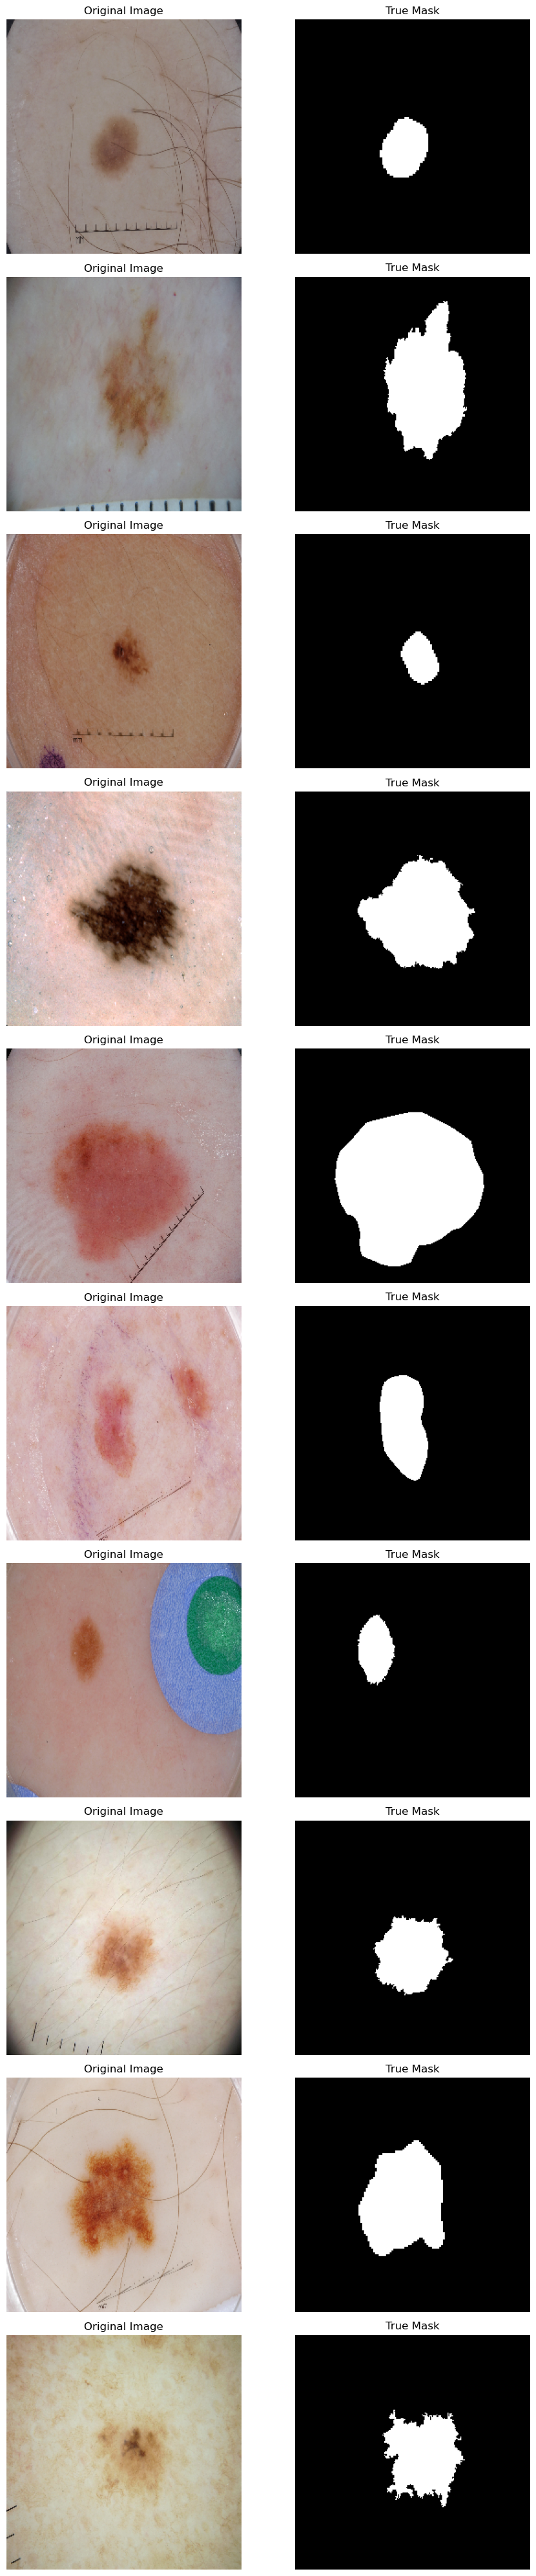

In [20]:
# Initial visualization of test images and true masks
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
for i in range(num_samples):
    img, true_mask = test_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    true_mask = true_mask.permute(1, 2, 0).squeeze().numpy()

    true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))
    true_mask_stacked = np.stack((true_mask_resized,) * 3, axis=-1)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(true_mask_stacked)
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

## Step 4: Load the Model
We load the trained model that we will use for inference. The model is a UNet architecture.

In [21]:
# Load trained model
model = UNet(n_channels=3, n_classes=1)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
  (conv6): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (conv7): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv8): Conv2d(256, 128, kernel_size=(3, 3), s

## Step 5: Make Predictions
We make predictions on the test dataset using the trained model. The model predicts a binary mask for each image. We visualize some of the predictions to see how well the model is performing.

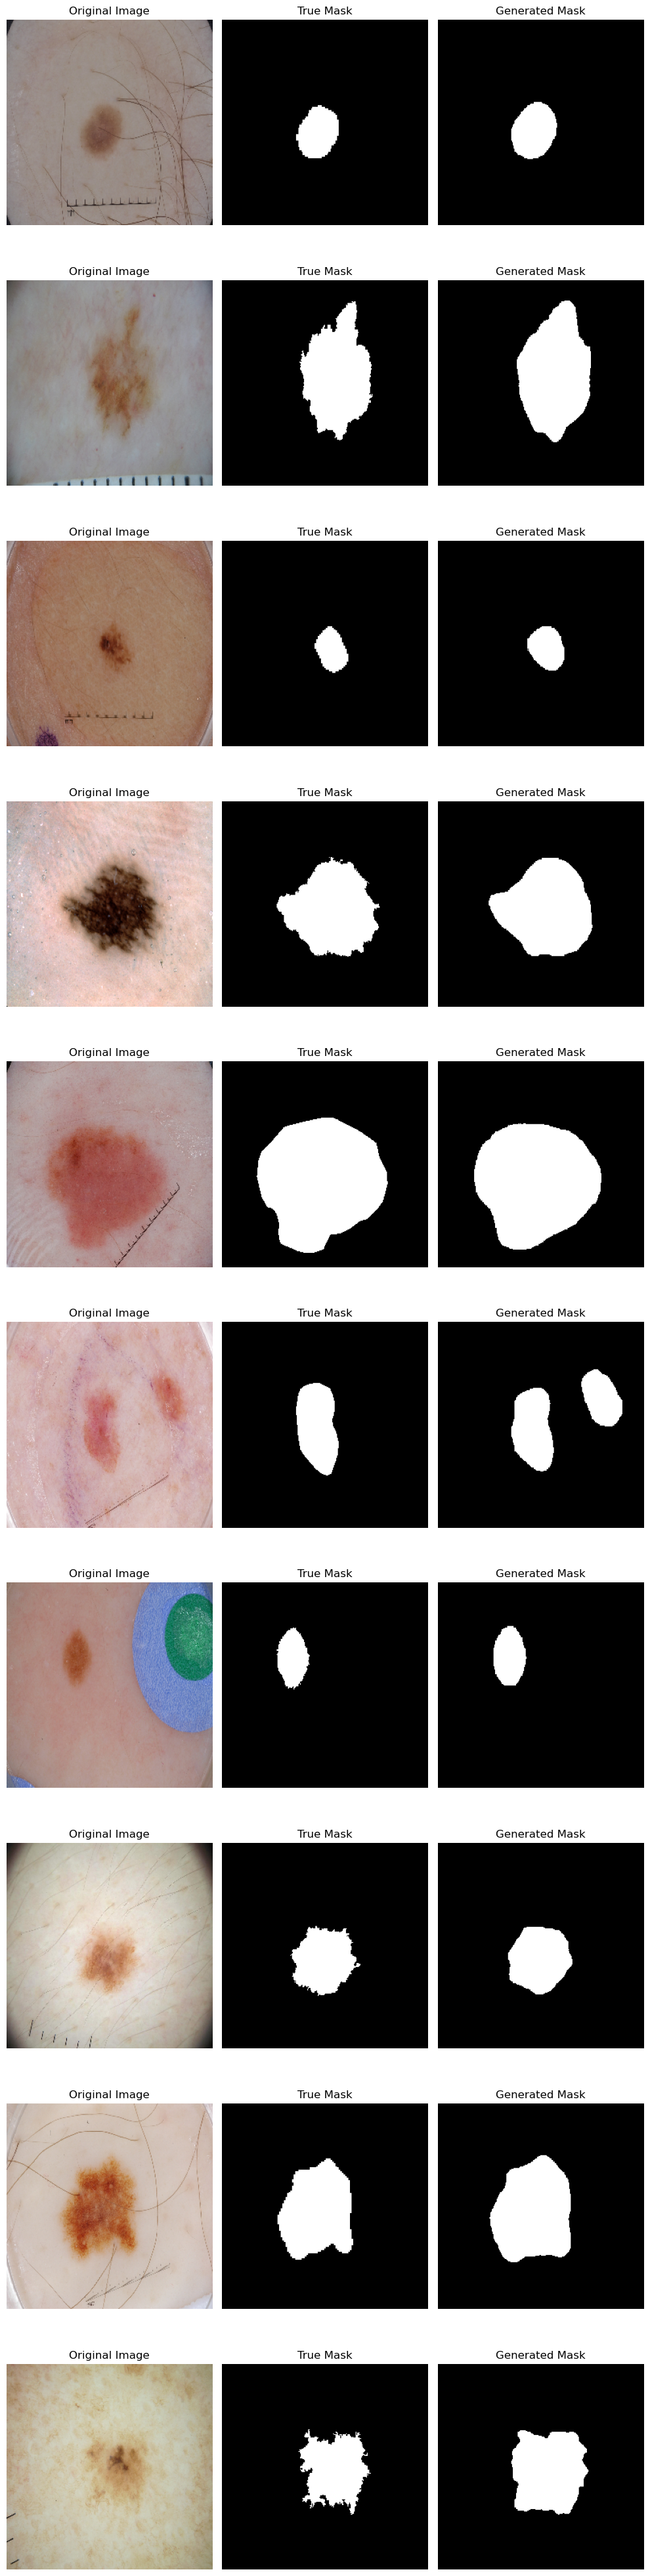

In [22]:
# Visualization with generated masks
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 4 * num_samples))
for i in range(num_samples):
    img, true_mask = test_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    true_mask = true_mask.permute(1, 2, 0).squeeze().numpy()

    with torch.no_grad():
        img_tensor = torch.Tensor(img).unsqueeze(0).permute(0, 3, 1, 2).to(device)
        generated_mask = model(img_tensor).squeeze().cpu().numpy()
        generated_mask = (generated_mask > 0.5).astype(np.float32)

    true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))
    true_mask_stacked = np.stack((true_mask_resized,) * 3, axis=-1)

    generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
    generated_mask_stacked = np.stack((generated_mask_resized,) * 3, axis=-1)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(true_mask_stacked)
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(generated_mask_stacked)
    axes[i, 2].set_title('Generated Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()